In [1]:
import os
for dirname, _, filenames in os.walk('/Users/ripper7/Desktop/MLCBP'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install python_speech_features

In [3]:
#import libraries
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator

In [4]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [5]:
#define a function to get distance between feature vectors and find neighbors
def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [6]:
#function to identify the nearest neighbors
def nearestclass(neighbors):
    classVote = {}
    
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
            
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [7]:
# define a function that will evaluate a model
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == prediction[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

In [8]:
import librosa
import IPython

def load_and_display_audio(file_path, target_sr=22050):
    try:
        # Load audio with a target sampling rate
        signal, sr = librosa.load(file_path, sr=target_sr)
        
        # Display the audio
        IPython.display.display(IPython.display.Audio(signal, rate=sr))
        
        return signal, sr
    except Exception as e:
        print(f"Error loading audio file: {e}")

# Example usage
file_path = '/Users/ripper7/Desktop/MLCBP/Data/genres_original/disco/disco.00031.wav'
signal, sr = load_and_display_audio(file_path)

Error loading audio file: module 'soundfile' has no attribute 'SoundFileRuntimeError'


TypeError: cannot unpack non-iterable NoneType object

In [11]:
import os
import pickle
from scipy.io import wavfile as wav
from python_speech_features import mfcc
import numpy as np

directory = '/Users/ripper7/Desktop/MLCBP/Data/genres_original'
output_file = "my.dat"

with open(output_file, "wb") as f:
    i = 0
    for folder in os.listdir(directory):
        i += 1
        if i == 11:
            break

        folder_path = os.path.join(directory, folder)

        # Skip non-directory files
        if not os.path.isdir(folder_path):
            continue

        print(f"Processing files in {folder} folder")

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            # Skip non-wav files
            if not file.endswith('.wav'):
                continue

            try:
                (rate, sig) = wav.read(file_path)
                mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
                covariance = np.cov(np.transpose(mfcc_feat))
                mean_matrix = np.mean(mfcc_feat, axis=0)
                feature = (mean_matrix, covariance, i)
                pickle.dump(feature, f)
            except Exception as e:
                print("Got an exception:", e, 'in folder:', folder, 'filename:', file)


Processing files in pop folder
Processing files in metal folder
Processing files in disco folder
Processing files in blues folder
Processing files in reggae folder
Processing files in classical folder
Processing files in rock folder
Processing files in hiphop folder
Processing files in country folder


In [13]:
#split dataset into train and test set
import random
dataset = []

def loadDataset(filename, split, trset, teset):
    with open('my.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset('my.dat', 0.66, trainingSet, testSet)

In [14]:
# Make the prediction using KNN(K nearest Neighbors)
length = len(testSet)
predictions = []
for x in range(length):
    predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

0.720125786163522


In [15]:
from collections import defaultdict
results = defaultdict(int)

directory = "/Users/ripper7/Desktop/MLCBP/Data/genres_original"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [16]:
pred = nearestclass(getNeighbors(dataset, feature, 5))
print(results[pred])

country


In [17]:
new_file = r"/Users/ripper7/Downloads/Weird_serious_jingle_of_death.wav"
new_signal, new_sr = librosa.load(new_file, sr=22050)

# Extract MFCC features from the new audio file
new_mfcc_feat = mfcc(new_signal, new_sr, winlen=0.020, appendEnergy=False)
new_covariance = np.cov(np.matrix.transpose(new_mfcc_feat))
new_mean_matrix = new_mfcc_feat.mean(0)
new_feature = (new_mean_matrix, new_covariance, 0)  # Assuming label 0 for the new file

# Make the prediction for the new audio file using KNN
new_prediction = nearestclass(getNeighbors(trainingSet, new_feature, 5))

# Print the predicted genre
print("Predicted Genre:", results[new_prediction])

Predicted Genre: hiphop


Accuracy: 0.720125786163522
Precision: 0.7325153038203354
Recall: 0.720125786163522
F1 Score: 0.7220578612211663


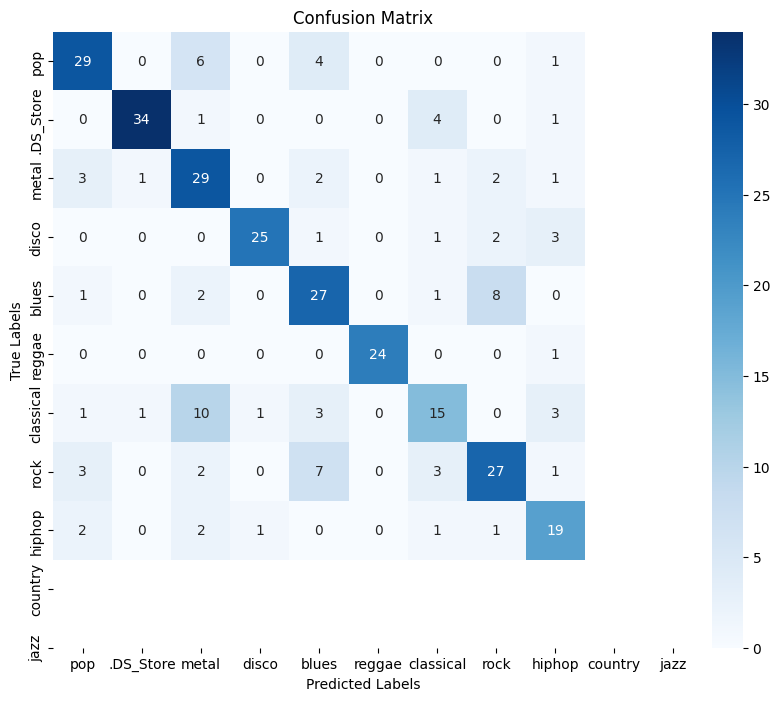

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate performance metrics
def evaluate_performance(true_labels, predicted_labels, classes):
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Print metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Create a confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


true_labels = [instance[-1] for instance in testSet]


predictions = [nearestclass(getNeighbors(trainingSet, instance, 5)) for instance in testSet]


classes = [results[i] for i in range(1, len(results) + 1)]

# Evaluate performance
evaluate_performance(true_labels, predictions, classes)